In [1]:
# Without suppressing messages, this prints a big pink block which hurts readability
suppressMessages({
library(ggplot2)
library(rethinking)
library(mlbench)
library(tidyverse)
library(GGally)
library(data.table)
    })

# Linear Regression (with quap)
+ Data - [mlbench library Boston Housing Dataset](http://math.furman.edu/~dcs/courses/math47/R/library/mlbench/html/BostonHousing.html)
+ Reference Kaggle Analysis Notebooks
    + https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset
    + https://www.kaggle.com/code/tolgahancepel/boston-housing-regression-analysis

Description

Housing data for 506 census tracts of Boston from the 1970 census. The dataframe BostonHousing contains the original data by Harrison and Rubinfeld (1979), the dataframe BostonHousing2 the corrected version with additional spatial information (see references below). 

The original data are 506 observations on 14 variables, medv being the target variable:
+ **crim** 	per capita crime rate by town
+ **zn** 	proportion of residential land zoned for lots over 25,000 sq.ft
+ **indu**s 	proportion of non-retail business acres per town
+ **chas** 	Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
+ **nox** 	nitric oxides concentration (parts per 10 million)
+ **rm** 	average number of rooms per dwelling
+ **age** 	proportion of owner-occupied units built prior to 1940
+ **dis** 	weighted distances to five Boston employment centres
+ **rad** 	index of accessibility to radial highways
+ **tax** 	full-value property-tax rate per USD 10,000
+ **ptratio** 	pupil-teacher ratio by town
+ **b** 	1000(B - 0.63)^2 where B is the proportion of blacks by town
+ **lstat** 	percentage of lower status of the population
+ **medv** 	median value of owner-occupied homes in USD 1000's

The corrected data set has the following additional columns:
+ **cmedv** 	corrected median value of owner-occupied homes in USD 1000's
+ **town** 	name of town
+ **tract** 	census tract
+ **lon** 	longitude of census tract
+ **lat** 	latitude of census tract 

# Data

In [2]:
data(BostonHousing2)
# data(milk)
d <- as_tibble(BostonHousing2)
d <- d[, c("crim", 'zn', "town", "chas", "rm", "lstat", "cmedv")]
d <- d %>% 
  rename(
    crime_rate = crim,
    perc_zoned_25k = zn,
    adj_river = chas,
    mean_rooms = rm,
    perc_lower_status = lstat,
    median_price = cmedv    
    )
d_orig <- data.frame(d)
str(d_orig)
head(d_orig)

'data.frame':	506 obs. of  7 variables:
 $ crime_rate       : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ perc_zoned_25k   : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ town             : Factor w/ 92 levels "Arlington","Ashland",..: 54 77 77 46 46 46 69 69 69 69 ...
 $ adj_river        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mean_rooms       : num  6.58 6.42 7.18 7 7.15 ...
 $ perc_lower_status: num  4.98 9.14 4.03 2.94 5.33 ...
 $ median_price     : num  24 21.6 34.7 33.4 36.2 28.7 22.9 22.1 16.5 18.9 ...


,crime_rate,perc_zoned_25k,town,adj_river,mean_rooms,perc_lower_status,median_price
,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,0.00632,18,Nahant,0,6.575,4.98,24.0
2,0.02731,0,Swampscott,0,6.421,9.14,21.6
3,0.02729,0,Swampscott,0,7.185,4.03,34.7
4,0.03237,0,Marblehead,0,6.998,2.94,33.4
5,0.06905,0,Marblehead,0,7.147,5.33,36.2
6,0.02985,0,Marblehead,0,6.430,5.21,28.7


# Data Review
## Continuous Variables 

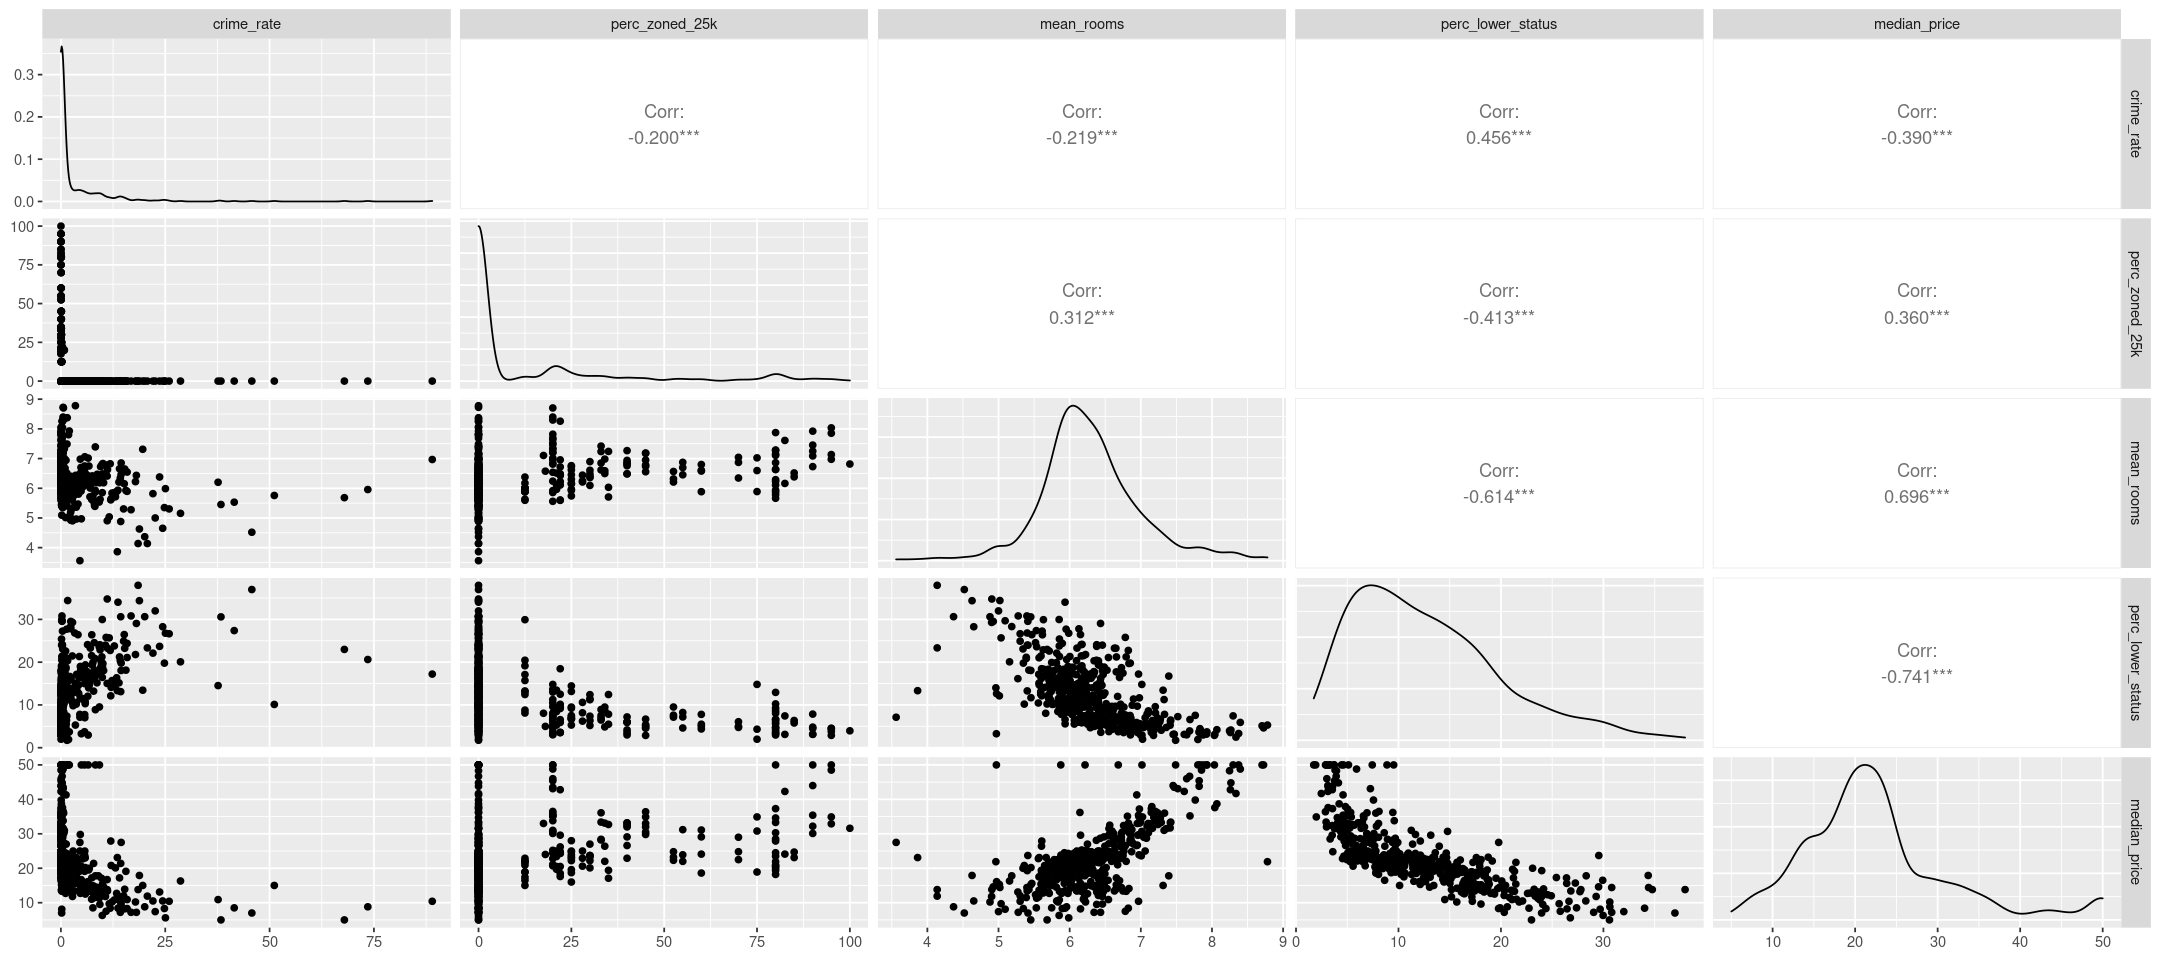

In [3]:
options(repr.plot.width=18, repr.plot.height=8)
ggpairs(d_orig, columns=c("crime_rate", "perc_zoned_25k", "mean_rooms", "perc_lower_status", "median_price"))

## Categorical Variables - TODO 

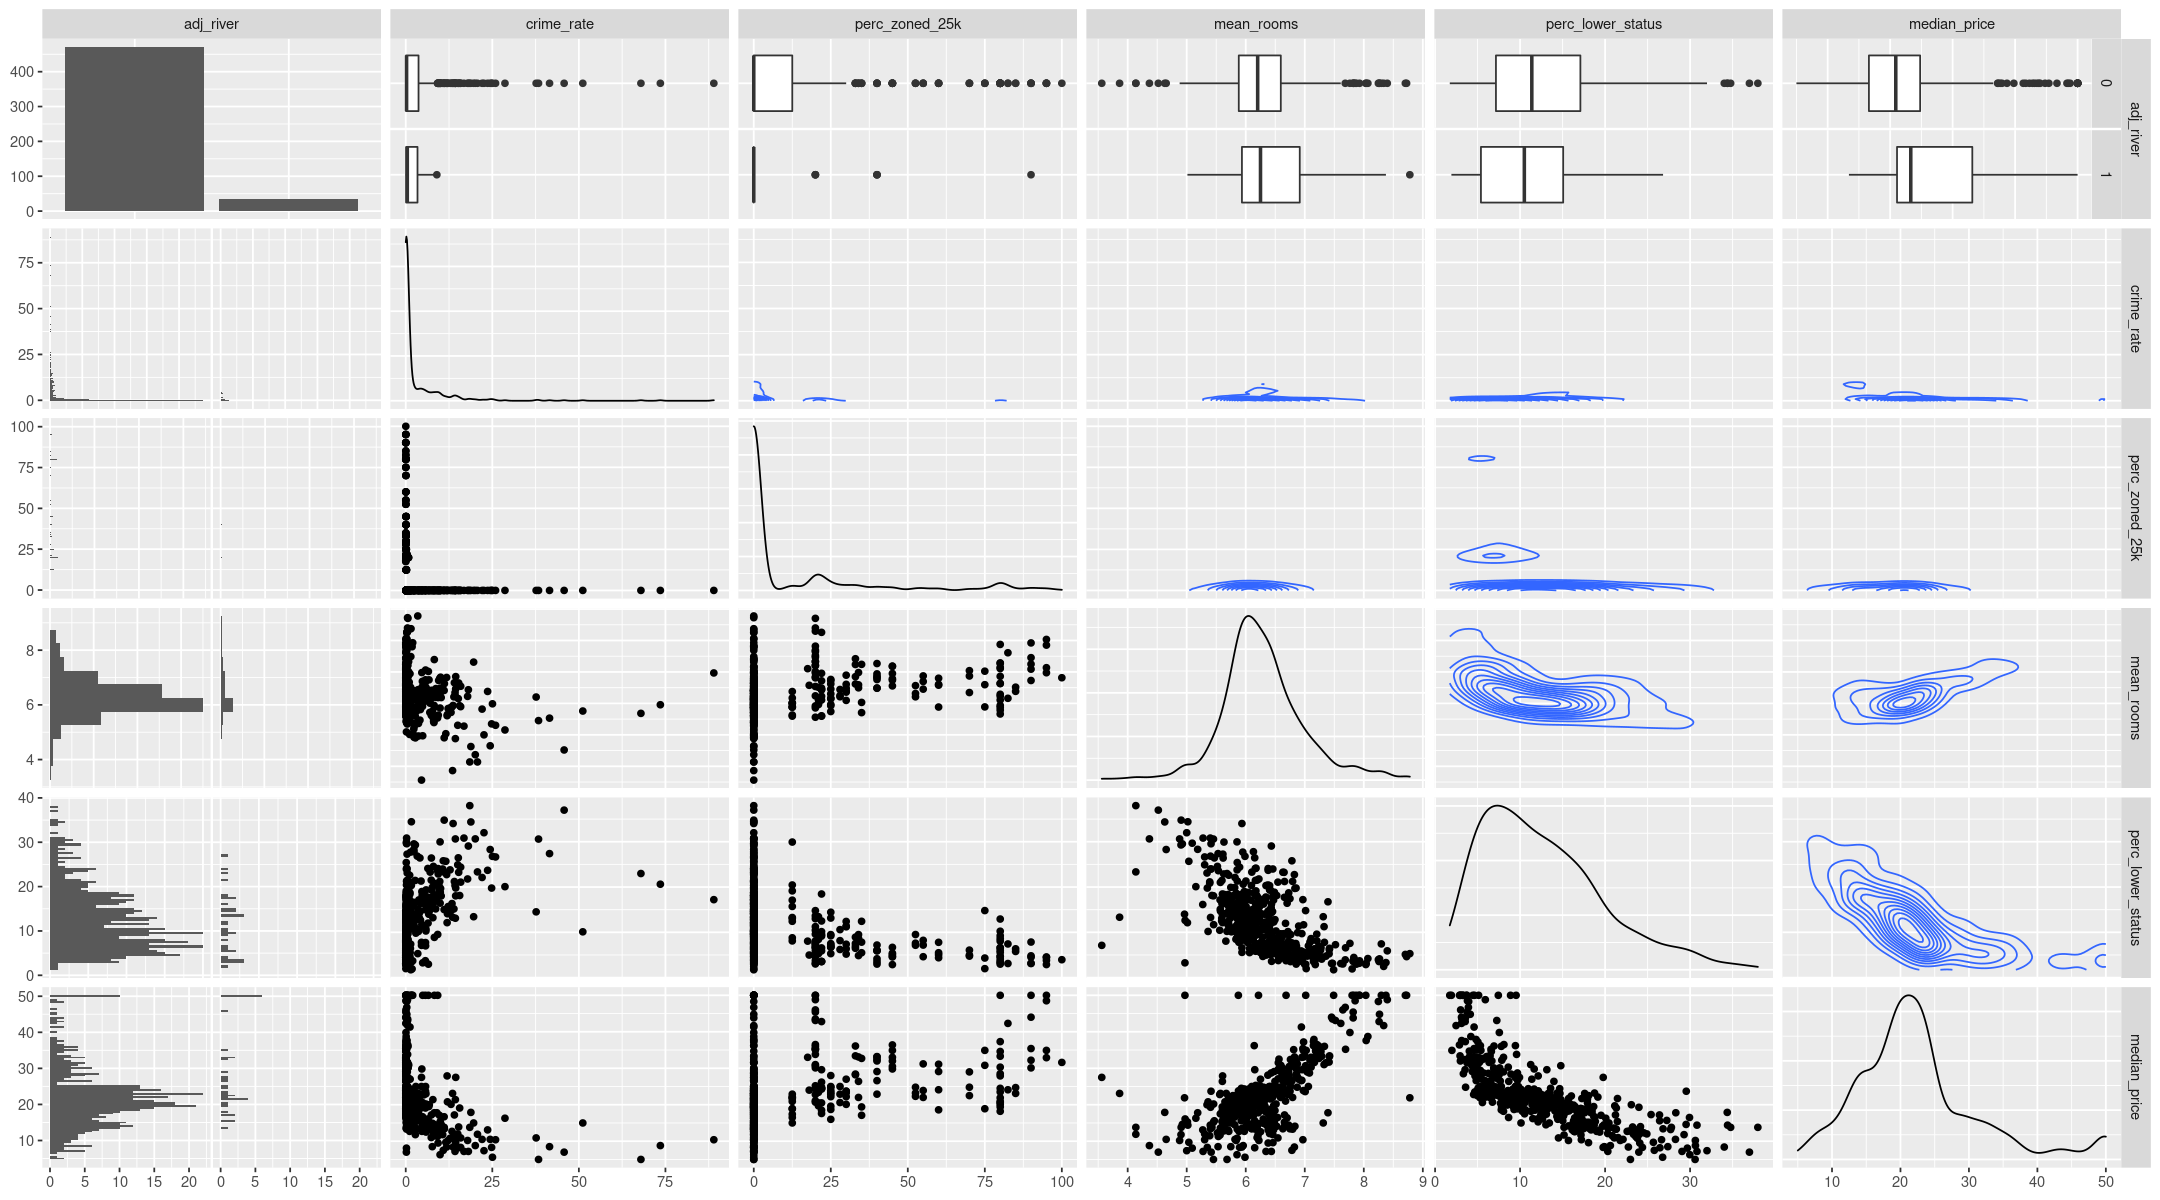

In [4]:
# Only want the top row of this
# want to do the same for the towns
# The plot text is so small it is nearly unreadable. Investigate fontsize
options(repr.plot.width=18, repr.plot.height=10)
ggpairs(d_orig, columns=c("adj_river", "crime_rate", "perc_zoned_25k", "mean_rooms", "perc_lower_status", "median_price"),
        upper=list(continuous="density", combo="box"),
       lower=list(combo=wrap("facethist", binwidth=0.5)))

# 1.0 Single Variable Linear Regression - Mean Number of Rooms vs Price - 

## 1.1 Prepare data for Modeling
+ Standardize / Normalize(?) / Scale (?) the Continuous predictors
+ Set index numbers for the categorical variables
+ Take the log of the outcome, and standardize

In [5]:
d <- copy(d_orig)
d$crime_rate_std <- scale(d$crime_rate)
d$perc_zoned_25k_std <- scale(d$perc_zoned_25k)
d$num_rooms_std <- scale(d$mean_rooms)
d$perc_lower_status_std <- scale(d$perc_lower_status)
d$price_stdlog <- scale(log(d$median_price))
str(d)
# Note that the dataframe stores attributes for the scaled columns - mean and stdev called center and scale
# Maybe the purpose of these is to enable getting back to the original data

'data.frame':	506 obs. of  12 variables:
 $ crime_rate           : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ perc_zoned_25k       : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ town                 : Factor w/ 92 levels "Arlington","Ashland",..: 54 77 77 46 46 46 69 69 69 69 ...
 $ adj_river            : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mean_rooms           : num  6.58 6.42 7.18 7 7.15 ...
 $ perc_lower_status    : num  4.98 9.14 4.03 2.94 5.33 ...
 $ median_price         : num  24 21.6 34.7 33.4 36.2 28.7 22.9 22.1 16.5 18.9 ...
 $ crime_rate_std       : num [1:506, 1] -0.419 -0.417 -0.417 -0.416 -0.412 ...
  ..- attr(*, "scaled:center")= num 3.61
  ..- attr(*, "scaled:scale")= num 8.6
 $ perc_zoned_25k_std   : num [1:506, 1] 0.285 -0.487 -0.487 -0.487 -0.487 ...
  ..- attr(*, "scaled:center")= num 11.4
  ..- attr(*, "scaled:scale")= num 23.3
 $ num_rooms_std        : num [1:506, 1] 0.413 0.194 1.281 1.015 1.227 ...
  ..- attr(*, "scaled:center")= num 6

In [6]:
class (d$crime_rate) # - original
class(d$crime_rate_std) # - scaling creates a matrix
class(d$crime_rate_std[,1]) # - scaled values can be got here - seems a bit awkward - also seems like R starts counting columns from 1 not 0
# d$crime_rate_std[,1] # - gets the scaled values

[1] "numeric"

[1] "matrix" "array"

[1] "numeric"

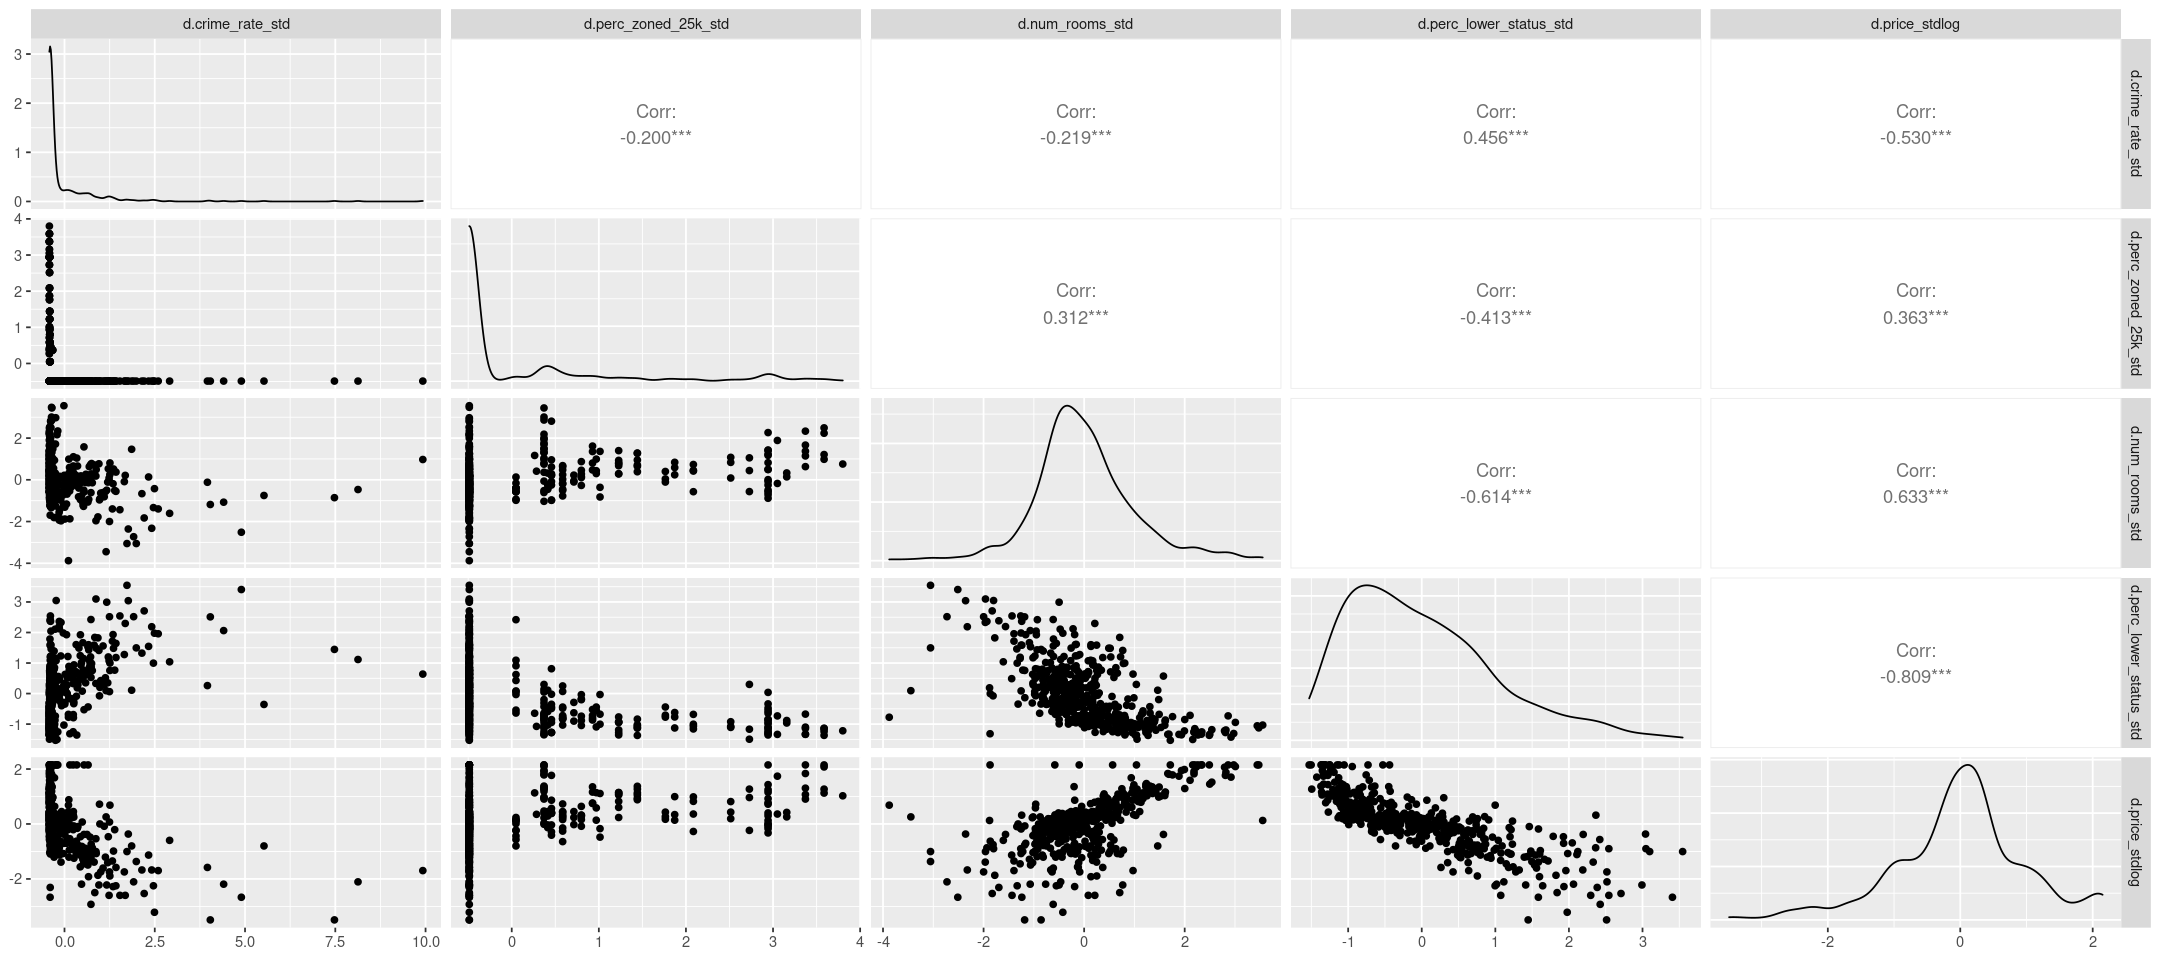

In [7]:
options(repr.plot.width=18, repr.plot.height=8)
# ggpairs(d, columns=c("crime_rate_std", "perc_zoned_25k_std", "num_rooms_std", "perc_lower_status_std", "price_logstd"))
# ggpairs(data.frame(d), columns=c("crime_rate_std", "perc_zoned_25k_std")) # ", "num_rooms_std", "perc_lower_status_std", "price_logstd"))
ggpairs(data.frame(d$crime_rate_std, d$perc_zoned_25k_std, d$num_rooms_std, d$perc_lower_status_std, d$price_stdlog))

## 1.2 Plot the Data 

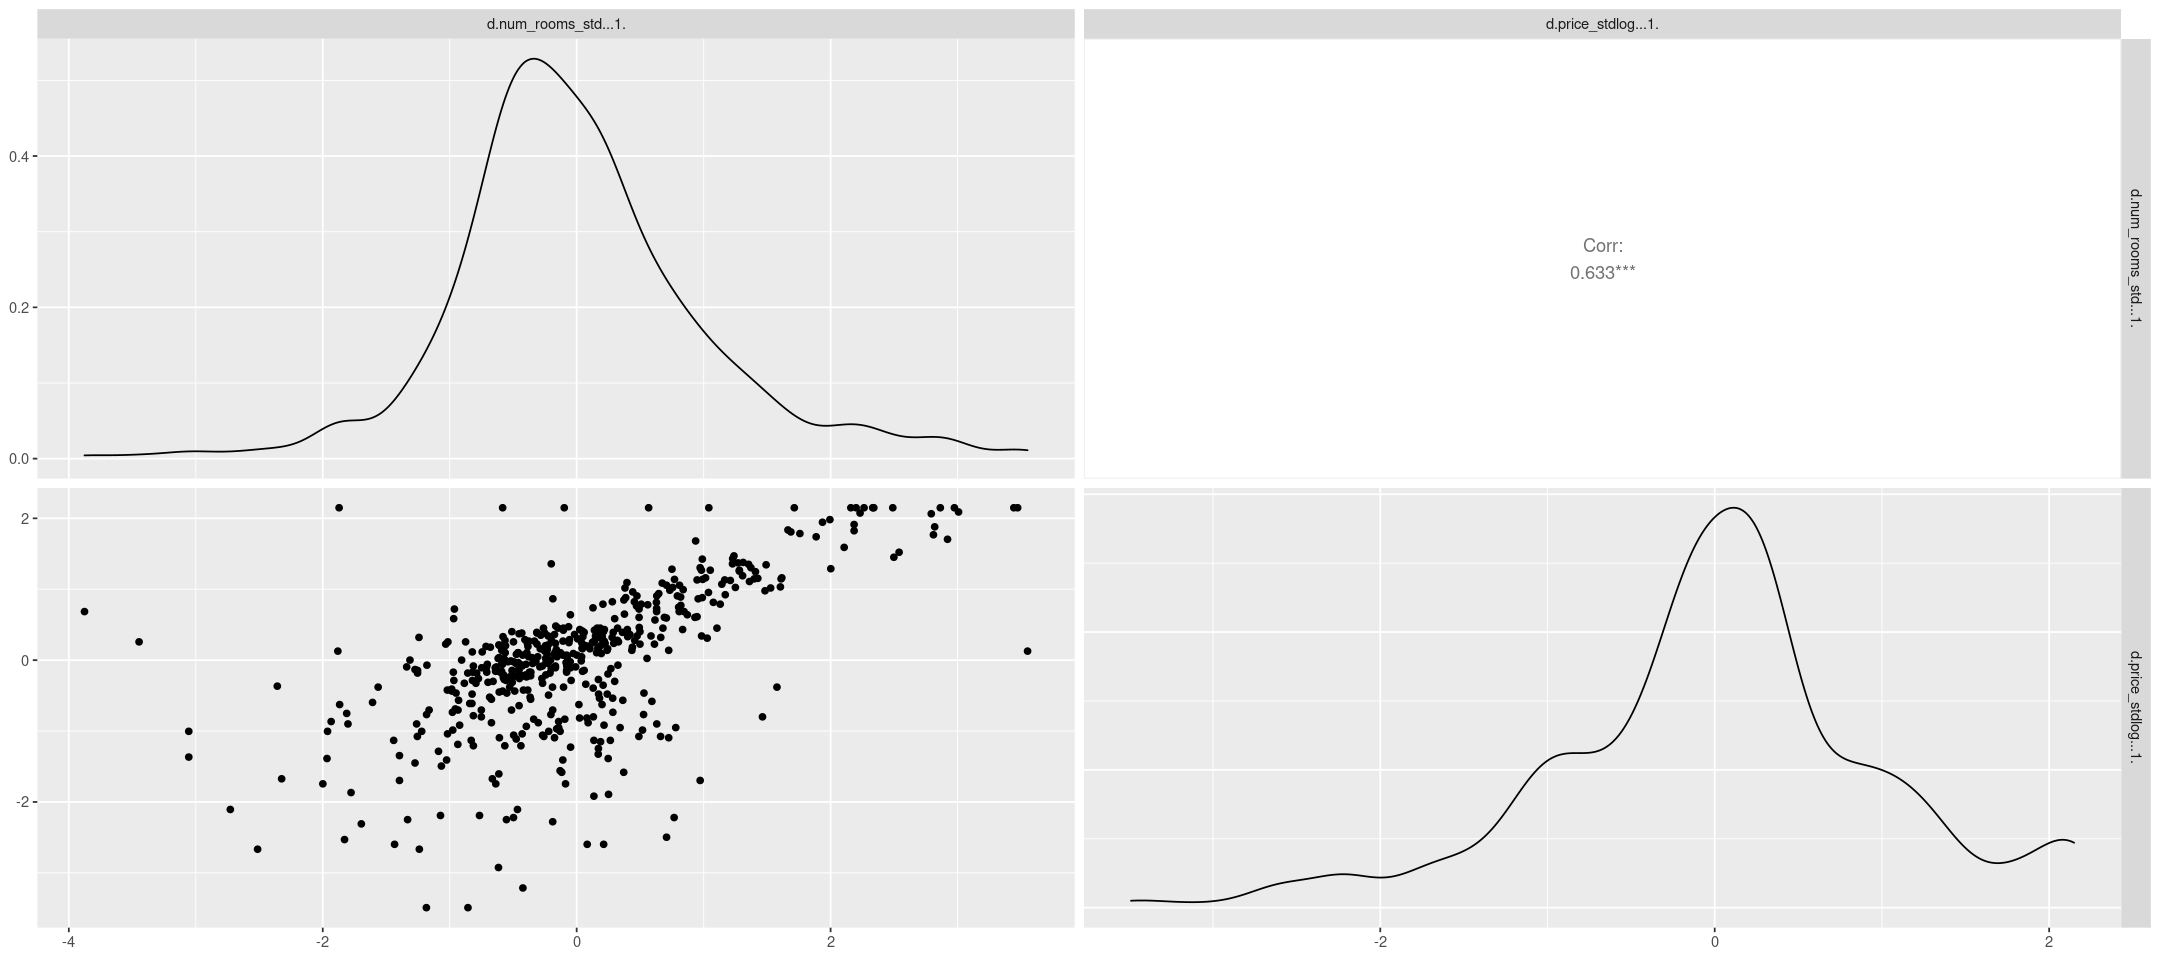

In [8]:
options(repr.plot.width=18, repr.plot.height=8)
ggpairs(data.frame(d$num_rooms_std[,1], d$price_stdlog[,1]))

## 1.3 Define the Model

+ The model
    + $price_i \sim Normal(\mu_i, \sigma)$ [likelihood]
    + *$u_i = \alpha + \beta_r(num\_rooms_i - \bar{num\_rooms})$ [linear model is: mu_i = alpha + beta_r(num_rooms_i - mean_num_rooms)]*
    + **[Selected Model] $u_i = \alpha + \beta_rnum\_rooms_i)$ [linear model is: mu_i = alpha + beta_r * num_rooms_i]**
    + $\alpha \sim Normal(0, 0.2)$ [alpha prior]
    + $\beta_r \sim Normal(0, 0.5)$ [beta prior]
    + $\sigma \sim Exponential(1)$ [sigma prior]
    + Notes on variables:
        + Price is actually log of price which is then scaled
        + Num rooms is scaled

## 1.4 Code the Model 

In [9]:
# Model as Code
m1.0 <- quap(
    alist(
        price_stdlog ~ dnorm(mu, sigma), # likelihood
        mu <- a + br * num_rooms_std, # linear model
        a ~ dnorm( 0, 0.2), # alpha prior
        br ~ dnorm(0, 0.5), # beta prior
        sigma ~ dexp(1) # sigma prior
    ), data=d)

## 1.5 Simulate Priors & Review for Validity

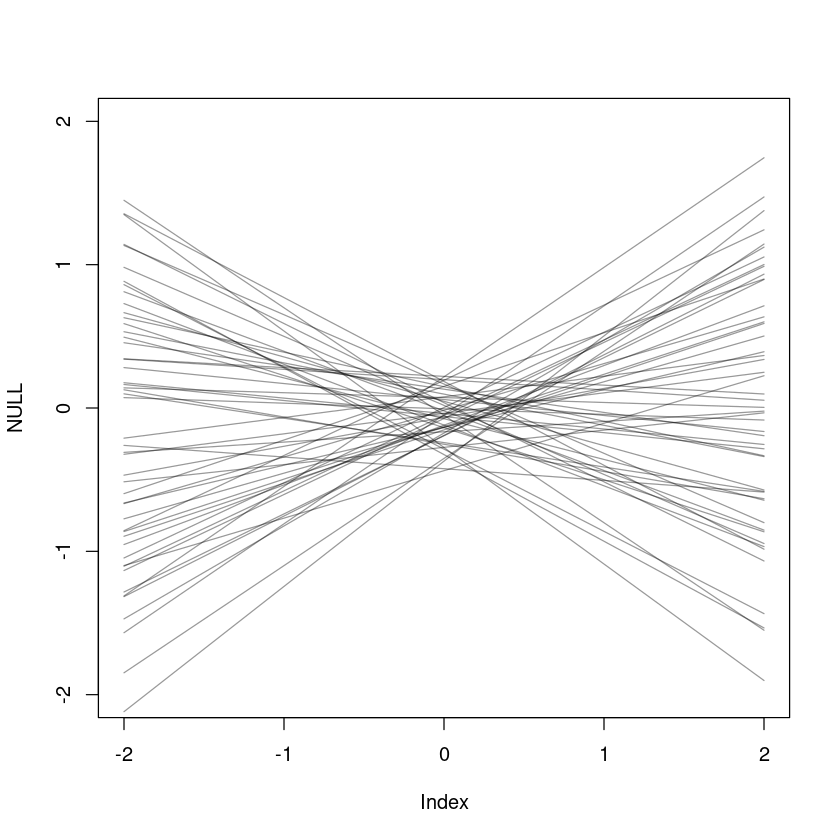

In [10]:
options(repr.plot.width=7, repr.plot.height=7)
set.seed(10)
prior <- extract.prior(m1.0)
mu <- link(m1.0, post=prior, data=list(num_rooms_std=c(-2,2))) # Change this line to suit your variable
plot(NULL, xlim=c(-2, 2), ylim=c(-2,2))
for ( i in 1:50) lines(c(-2,2), mu[i,], col=col.alpha("black", 0.4))

### Review
+ These look OK? - Not 100% sure what to look for here

## 1.6 Plot Posterior Distributions
+ Check that these are 89% lines, and see how to change lines - TODO
+ These are pretty meaningless unless they are converted back to number of rooms and dollars
+ Want to be able to see how many extra $ we pay for an additional room

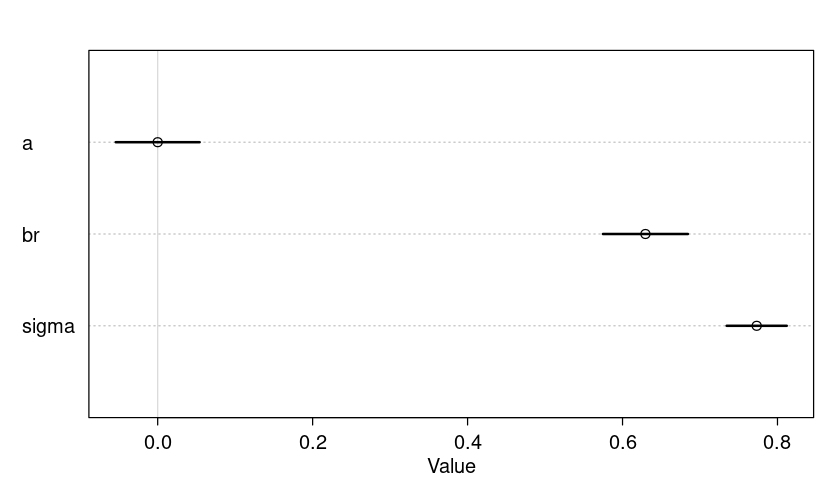

In [11]:
options(repr.plot.width=7, repr.plot.height=4)
plot(precis(m1.0))

## 1.7 Plot Model and Data

In [12]:
# compute percentile interval of mean
A_seq <- seq(from=-3, to=3.2, length.out=30)
mu <- link(m1.0, data=list(num_rooms_std=A_seq)) # change this variable
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI)

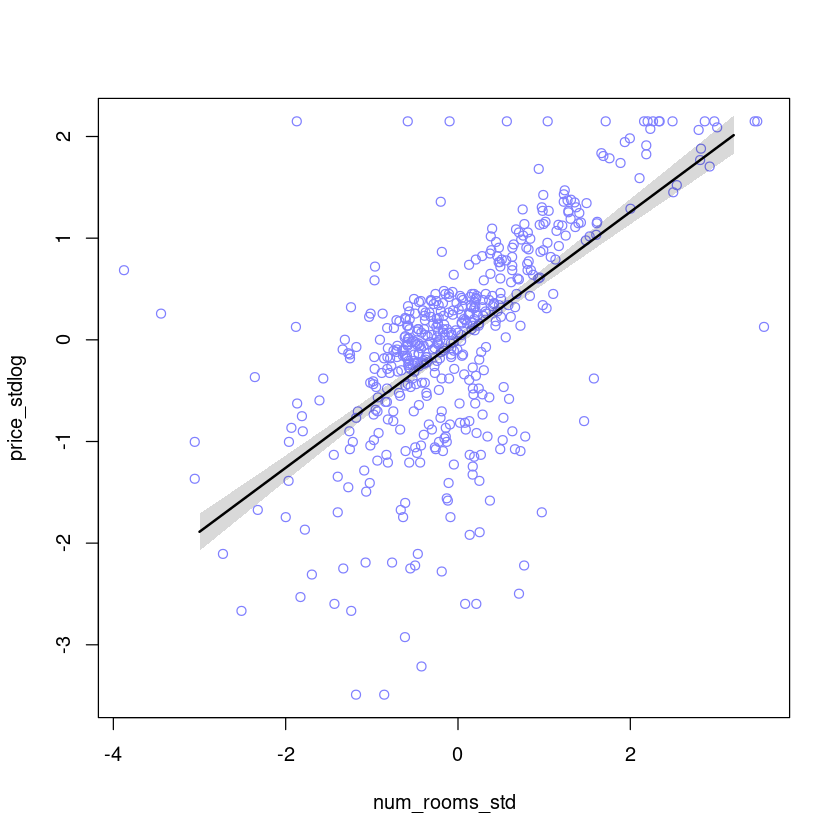

In [13]:
options(repr.plot.width=7, repr.plot.height=7)
plot(price_stdlog ~ num_rooms_std, data=d, col=rangi2) # Change this
lines(A_seq, mu.mean, lwd=2)
shade(mu.PI, A_seq)

## 1.8 Plot Prediction Intervals
+ The code below was from the height vs weight data in chapter 4, but my model is setup differently

In [14]:
# Original Book Code

# mu.mean <- apply(mu, 2, mean)
# mu.PI <- apply(mu, 2, PI, prob=0.89)
# # Plot data
# plot( height ~ weight , data=d2 , col=col.alpha(rangi2,0.5) )
# # Plot mean regression line
# lines( weight.seq , mu.mean )
# # Shade the PI
# shade( mu.PI , weight.seq )

# weight.seq <- seq(from=25, to=70, by=1)
# sim.height <- sim(m4.3, data=list(weight=weight.seq))
# str(sim.height)

# Code adapted
mu.mean <- apply(mu, 2, mean)
mu.PI <- apply(mu, 2, PI, prob=0.89)
num_rooms_std.seq <- seq(from=-4.0, to=4.0, by=0.13)
sim.price_stdlog <- sim(m1.0, data=list(num_rooms_std=num_rooms_std.seq))
str(sim.price_stdlog)

 num [1:1000, 1:62] -1.81 -3.791 -2.234 -0.958 -3.62 ...


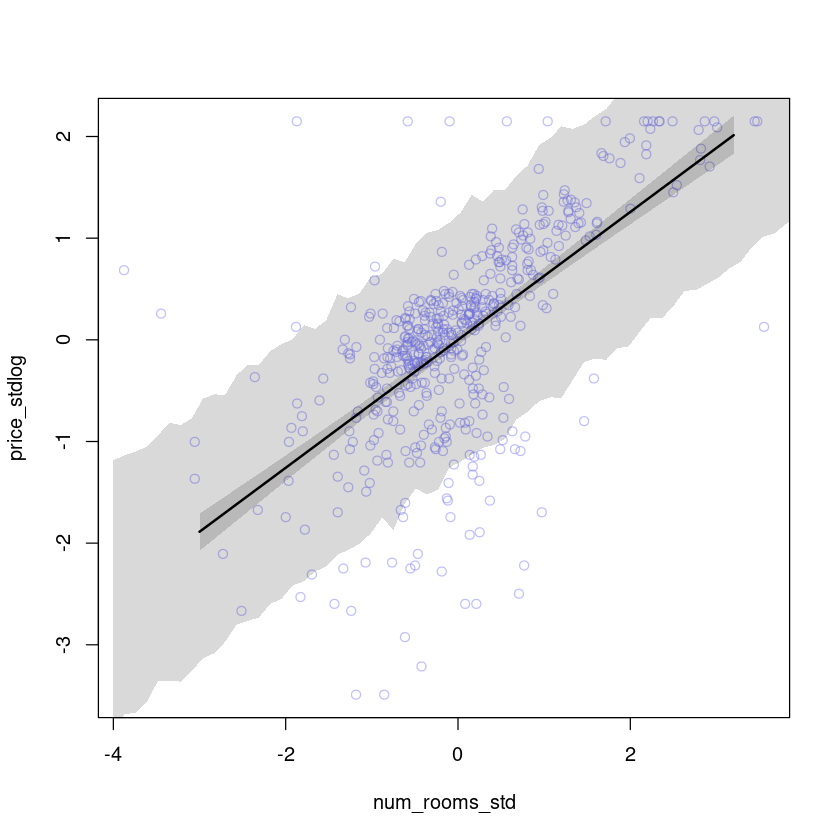

In [15]:
# Original book code
# height.PI <- apply(sim.height, 2, PI, prob=0.89)
# plot( height ~ weight , d2 , col=col.alpha(rangi2,0.5) )
# lines( weight.seq , mu.mean )
# shade( mu.PI , weight.seq ) - # Code error mu.HDPI in book
# shade( height.PI , weight.seq )

# code adapted
price_stdlog.PI <- apply(sim.price_stdlog, 2, PI, prob=0.89)
plot( price_stdlog ~ num_rooms_std , d , col=col.alpha(rangi2,0.5) )
# lines( numRooms.seq , mu.mean )
lines(A_seq, mu.mean, lwd=2)
# shade( mu.PI , priceLogStd.seq ) - # Code error mu.HDPI in book
shade(mu.PI, A_seq)
shade( price_stdlog.PI , num_rooms_std.seq )

+ This plot looks OK, but I want to be able to select a number of rooms, say 5, and get an estimate of minimum and maximum price for the property
+ I guess this can be done manually, but it seems a bit awkward
    + For example mean number of rooms is 6.28 - This is location 0 on the x axis.
    + The low end of the 89% prediction interval is say -1.5, and the upper end is about +1
    + Therefore the 89% price distribution is from exp( 3.03 + (-1.5 * 0.408)) to exp(3.03 + (1 * 0.408)) ie exp(2.418) to exp(3.438)
    + So, 89% prediction interval is 11.2K to 31.1K
+ It would be better if I could convert the posterior distributions to original units. Then it would be a bit easier to see if the values made sense.

## 1.9 TODO - Get relevant distributions in original units

# 2.0 Multiple Linear Regression

In [16]:
d <- copy(d_orig)
str(d)

'data.frame':	506 obs. of  7 variables:
 $ crime_rate       : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ perc_zoned_25k   : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ town             : Factor w/ 92 levels "Arlington","Ashland",..: 54 77 77 46 46 46 69 69 69 69 ...
 $ adj_river        : Factor w/ 2 levels "0","1": 1 1 1 1 1 1 1 1 1 1 ...
 $ mean_rooms       : num  6.58 6.42 7.18 7 7.15 ...
 $ perc_lower_status: num  4.98 9.14 4.03 2.94 5.33 ...
 $ median_price     : num  24 21.6 34.7 33.4 36.2 28.7 22.9 22.1 16.5 18.9 ...
